In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import pandas as pd
import backtest as twp

import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

from sklearn import metrics, preprocessing

In [2]:
def load_data(fun):
    if fun == 'line':
        price = np.arange(200/10.0) #linearly increasing prices
        return price
    if fun == 'sin':
        price =  np.sin(np.arange(200)/30.0) #sin prices        
        return price

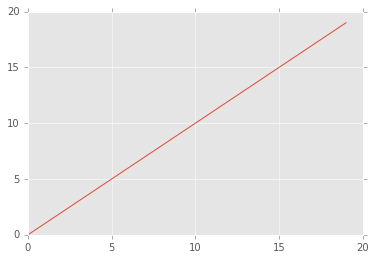

In [3]:
indata_line = load_data('line')
plt.figure()
plt.plot(indata_line)

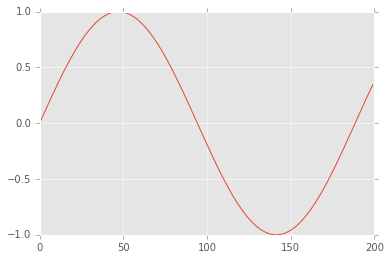

In [4]:
indata_sine = load_data('sin')
plt.figure()
plt.plot(indata_sine)

In [5]:
#indata = indata_line

In [6]:
# Initialize first state, all items are placed deterministically
def init_state(data):
    close = data
    diff = np.diff(data) 
    # diff: The first order difference is given by out[n] = a[n+1] - a[n]
    # x = np.array([1, 2, 4, 7, 0])
    # np.diff(x)
    # array([ 1,  2,  3, -7])
    diff = np.insert(diff,0,0)
    
    #-- Preprocess data
    xdata = np.column_stack((close, diff))
    xdata = np.nan_to_num(xdata)
    
    # Standardize features by removing the mean and scaling to unit variance
    scaler = preprocessing.StandardScaler()
    xdata = scaler.fit_transform(xdata)
    
    # Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 
    # Mean and standard deviation are then stored to be used on later data using the transform method.

    state = xdata[0:1,:]
    return state, xdata
    
    

In [7]:
# Take Action
def take_action(state, xdata, action, signal, time_step):
    # This should generate a list of trade signals that at evaluation time are fed to the backtester.
    # The backtester should get a list of trade signals and a list of price data for the asset
    
    # Make necessary adjustments to state and then run it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    if time_step == xdata.shape[0]:
        state = xdata[time_step-1:time_step,:]#??Maybe this outside the loop
        terminal_state = 1
        signal.loc[time_step] = 0 #loc: Purely label-location based indexer for selection by label.
        return state, time_step, signal, terminal_state
    
    # Move the market data window one step forward
    state = xdata[time_step-1:time_step,:] #?? Maybe this few lines up
    # take action!
    if action !=0:
        if action == 1:
            signal.loc[time_step] = 100
        elif action == 2:
            signal.loc[time_step] = -100
        elif action == 3:
            signal.loc[time_step] = 0
    terminal_state = 0
    
    return state, time_step, signal, terminal_state

In [8]:
# Get the reward. The reward is returned at the end of an epsilon
def get_reward(new_state, time_step, action, xdata, signal, terminal_steate, epoch=0):
    reward = 0
    signal.fillna(value=0, inplace=True)
    if terminal_state == 0:
        # get reward for the most current action
        if signal[time_step] != signal[time_step-1] and terminal_state == 0:
            i=1
            while signal[time_step-i] == signal[time_step-1-i] and time_step - 1 -i >0:
                i+=1
            reward = (xdata[time_step-1,0] -xdata[time_step-i-1,0])*signal[time_step-1]*-100 + i*np.abs(signal[time_step-1])/10.0
            
        if signal[time_step] == 0 and signal[time_step-1]==0: #maybe revise this??
            reward -=10 #??
            
    # calculate the reward for all actions if the last iteration in set
    if terminal_state == 1:
        # run backtest, send list of trade signals and asset data to backtest function
        bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
        reward = bt.pnl.iloc[-1]
        
    return reward

In [9]:
def evaluate_Q(eval_data, eval_model):
    # This function is used to evaluate the perfomance of the system each epoch, 
    # without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    while(status == 1):
        # We start in state S
        # Run the Q function on S to get predicted reward values on all the possible actions
        qval = eval_model.predict(state.reshape(1,2), batch_size=1)
        action = (np.argmax(qval))
        # Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        # Observe reward
        eval_reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        state = new_state
        if terminal_state == 1:
            status = 0
    return eval_reward


In [10]:
#This neural network is the Q-function, run it like this:
#model.predict(state.reshape(1,64), batch_size=1)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(4, kernel_initializer ='lecun_uniform', input_shape=(2,))) #LeCun uniform initializer.It draws samples from a uniform distribution within [-limit, limit] 
model.add(Activation('relu'))
#model.add(Dropout(0.2)) #maybe add later

model.add(Dense(4, kernel_initializer ='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(4, kernel_initializer ='lecun_uniform'))
model.add(Activation('linear')) #linear output, so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)




Using TensorFlow backend.


In [11]:
from keras.models import load_model

model.save('sin_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model



In [12]:
# returns a compiled model
# identical to the previous one
#model = load_model('sin_model.h5')


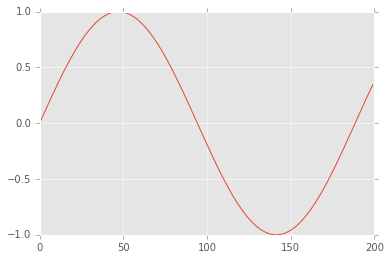

In [16]:
import random, timeit

start_time = timeit.default_timer()

indata = load_data('sin') # !! Chnage here
epochs = 100
gamma = 0.9 # a high gamma makes a long term reward more valubale
epsilon = 1
learning_progress = []
#store tuples of (S,A,R,S')
h = 0
signal = pd.Series(index=np.arange(len(indata))) # change here??


plt.figure()
plt.plot(indata)

In [17]:
# This should be main loop
for i in range(epochs):
    state, xdata = init_state(indata)
    status = 1 
    terminal_state = 0
    time_step = 1
    #while learning is still in progress
    while(status==1):
        #We start in state S
        #Run the Q function on S to get predicted reward on all the possible actions
        qval = model.predict(state.reshape(1,2), batch_size=1)
        if (random.random() < epsilon) and i != epochs - 1: #choose random action (to not stuck)
            action = np.random.randint(0,4) # assume 4 different actions
        else: # choose action from Q(s,a)
            action = (np.argmax(qval))
        
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        
        #Observe reward
        reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,2),batch_size=1)
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval[:]
        if terminal_state == 0: #none-terminal state
            update = (reward + (gamma * maxQ))
        else:
            update = reward
        y[0][action] = update
        model.fit(state.reshape(1,2),y,batch_size=1,epochs=1,verbose=0)
        state = new_state
        if terminal_state == 1: # terminal state
            status =0
    print("Epoch # %s Reward: %f Epsilon: %f" % (i,reward,epsilon))
    learning_progress.append((reward))
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)
        
elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

Epoch # 0 Reward: -28.674654 Epsilon: 1.000000
Epoch # 1 Reward: 15.970709 Epsilon: 0.990000
Epoch # 2 Reward: -36.448415 Epsilon: 0.980000
Epoch # 3 Reward: 11.938506 Epsilon: 0.970000
Epoch # 4 Reward: -32.751814 Epsilon: 0.960000
Epoch # 5 Reward: 40.468872 Epsilon: 0.950000
Epoch # 6 Reward: 5.753130 Epsilon: 0.940000
Epoch # 7 Reward: -18.092470 Epsilon: 0.930000
Epoch # 8 Reward: -58.904492 Epsilon: 0.920000
Epoch # 9 Reward: -13.512672 Epsilon: 0.910000
Epoch # 10 Reward: 4.046192 Epsilon: 0.900000
Epoch # 11 Reward: 85.032877 Epsilon: 0.890000
Epoch # 12 Reward: 81.040733 Epsilon: 0.880000
Epoch # 13 Reward: 10.130237 Epsilon: 0.870000
Epoch # 14 Reward: 54.635049 Epsilon: 0.860000
Epoch # 15 Reward: -0.814044 Epsilon: 0.850000
Epoch # 16 Reward: 69.223015 Epsilon: 0.840000
Epoch # 17 Reward: 75.282080 Epsilon: 0.830000
Epoch # 18 Reward: 45.563871 Epsilon: 0.820000
Epoch # 19 Reward: 66.174929 Epsilon: 0.810000
Epoch # 20 Reward: 141.905109 Epsilon: 0.800000
Epoch # 21 Reward:

        price  shares       value        cash         pnl  delta
0   -0.014472     0.0   -0.000000    0.000000    0.000000    0.0
1    0.033959     0.0    0.000000    0.000000    0.000000    0.0
2    0.082336   100.0    8.233615   -8.233615    0.000000  100.0
3    0.130606   100.0   13.060554   -8.233615    4.826939    0.0
4    0.178714   100.0   17.871375   -8.233615    9.637760    0.0
5    0.226607   100.0   22.660733   -8.233615   14.427118    0.0
6    0.274233   100.0   27.423307   -8.233615   19.189692    0.0
7    0.321538   100.0   32.153805   -8.233615   23.920190    0.0
8    0.368470   100.0   36.846973   -8.233615   28.613358    0.0
9    0.414976   100.0   41.497595   -8.233615   33.263980    0.0
10   0.461005   100.0   46.100506   -8.233615   37.866891    0.0
11   0.506506   100.0   50.650590   -8.233615   42.416975    0.0
12   0.551428   100.0   55.142794   -8.233615   46.909179    0.0
13   0.595721   100.0   59.572126   -8.233615   51.338511    0.0
14   0.639337   100.0   6

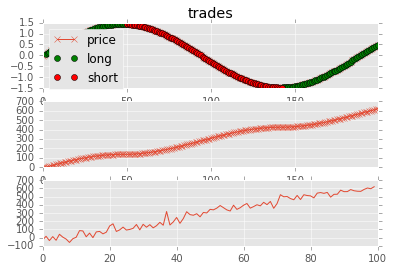

In [18]:
#Plot Results

bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)

plt.figure()
bt.plotTrades()
plt.suptitle('epoch' + str(i))
plt.savefig('final_trades'+'.png', bbox_inches='tight', pad_inches=1, dpi=72) # assumes there is a ./plt dir
plt.close('all')

plt.figure()
plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.show()
